In [ ]:
!pip install transformers[torch] datasets pandas scikit-learn seqeval accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"

arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

import pandas as pd
from sklearn.model_selection import train_test_split

def load_data(tokens_path, labels_path):
    with open(tokens_path, 'r', encoding='utf-8') as f:
        tokens_lines = f.readlines()
    with open(labels_path, 'r', encoding='utf-8') as f:
        labels_lines = f.readlines()

    sentences = [line.strip().split() for line in tokens_lines]
    labels = [line.strip().split() for line in labels_lines]
    return sentences, labels

def create_dataset(sentences, labels):
    data = {'tokens': sentences, 'ner_tags': labels}
    df = pd.DataFrame(data)
    return df

arman_sentences, arman_labels = load_data(arman_tokens_path, arman_labels_path)
arman_df = create_dataset(arman_sentences, arman_labels)

train_df, val_df = train_test_split(arman_df, test_size=0.1, random_state=42)

peyma_sentences, peyma_labels = load_data(peyma_tokens_path, peyma_labels_path)
test_df = create_dataset(peyma_sentences, peyma_labels)

print("Data Loading and Splitting Complete:")
print(f"Training Set (from ArmanNER): {len(train_df)} samples")
print(f"Validation Set (from ArmanNER): {len(val_df)} samples")
print(f"Test Set (from PeymaNER): {len(test_df)} samples")

Data Loading and Splitting Complete:
Training Set (from ArmanNER): 20738 samples
Validation Set (from ArmanNER): 2305 samples
Test Set (from PeymaNER): 9979 samples


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from seqeval.scheme import IOB2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score as sklearn_f1
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)

# مسیرها
DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"
arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

def normalize_labels(labels):
    normalized_labels = []
    for seq in labels:
        normalized_seq = [label.replace('_', '-') for label in seq]
        normalized_labels.append(normalized_seq)
    return normalized_labels

def load_data(tokens_path, labels_path):
    with open(tokens_path, 'r', encoding='utf-8') as f:
        tokens_lines = [line.strip().split() for line in f]
    with open(labels_path, 'r', encoding='utf-8') as f:
        labels_lines = [line.strip().split() for line in f]

    labels_lines = normalize_labels(labels_lines)
    data = {'tokens': [], 'ner_tags': []}
    for tokens, labels in zip(tokens_lines, labels_lines):
        if len(tokens) == len(labels):
            data['tokens'].append(tokens)
            data['ner_tags'].append(labels)
    return pd.DataFrame(data)

print("--- Step 1: Loading and Splitting Data ---")
arman_df  = load_data(arman_tokens_path, arman_labels_path)
train_df, val_df = train_test_split(arman_df, test_size=0.1, random_state=42)
test_df   = load_data(peyma_tokens_path, peyma_labels_path)

raw_datasets = DatasetDict({
    "train":      Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test":       Dataset.from_pandas(test_df.reset_index(drop=True))
})

print(f"Train: {len(raw_datasets['train'])}, Val: {len(raw_datasets['validation'])}, Test: {len(raw_datasets['test'])}")

print("\n--- Step 2: Label Dictionaries and Tokenization ---")
all_labels = [lab for seq in train_df['ner_tags'] for lab in seq]
label_names = sorted(set(all_labels))
label2id = {l: i for i, l in enumerate(label_names)}
id2label = {i: l for l, i in label2id.items()}
o_tag_id = label2id.get('O', -100)

def tokenize_and_align_labels(examples, tokenizer):
    tokenized = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )
    labels = []
    for i, lab_seq in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_idx = None
        lab_ids = []
        for idx in word_ids:
            if idx is None:
                lab_ids.append(-100)
            elif idx != prev_idx:
                label = lab_seq[idx]
                lab_ids.append(label2id.get(label, o_tag_id))
            else:
                lab_ids.append(-100)
            prev_idx = idx
        labels.append(lab_ids)
    tokenized["labels"] = labels
    return tokenized

def compute_metrics(p):
    logits    = p.predictions
    label_ids = p.label_ids
    preds     = np.argmax(logits, axis=-1)

    true_labels = []
    true_preds  = []
    for pred_seq, lab_seq in zip(preds, label_ids):
        for pred_id, lab_id in zip(pred_seq, lab_seq):
            if lab_id != -100:
                true_labels.append(lab_id)
                true_preds .append(pred_id)

    overall_accuracy = accuracy_score(true_labels, true_preds)
    overall_f1       = sklearn_f1(true_labels, true_preds, average='micro', zero_division=0)

    # macro & weighted
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        true_labels, true_preds, average='macro',    zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        true_labels, true_preds, average='weighted', zero_division=0
    )

    return {
        "overall_accuracy":   overall_accuracy,
        "overall_f1":         overall_f1,
        "macro_precision":    precision_macro,
        "macro_recall":       recall_macro,
        "macro_f1":           f1_macro,
        "weighted_precision": precision_weighted,
        "weighted_recall":    recall_weighted,
        "weighted_f1":        f1_weighted,
    }

model_checkpoints = [
    "HooshvareLab/bert-base-parsbert-uncased",
    "bert-base-multilingual-cased"
]

for checkpoint in model_checkpoints:
    print(f"\n=== Training: {checkpoint} ===")
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    config = AutoConfig.from_pretrained(
        checkpoint,
        num_labels=len(label_names),
        id2label=id2label,
        label2id=label2id
    )
    model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)

    tokenized_datasets = raw_datasets.map(
        tokenize_and_align_labels,
        batched=True,
        fn_kwargs={"tokenizer": tokenizer},
        remove_columns=raw_datasets["train"].column_names
    )

    args = TrainingArguments(
        output_dir=f"{checkpoint.split('/')[-1]}-finetuned-ner",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        num_train_epochs=3,
        weight_decay=0.01,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        load_best_model_at_end=True,
        metric_for_best_model="overall_f1",
        greater_is_better=True,
        push_to_hub=False,
    )

    data_collator = DataCollatorForTokenClassification(tokenizer)
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    trainer.train()
    print("\n--- Final Evaluation on Test Set ---")
    test_results = trainer.predict(tokenized_datasets["test"])
    for k, v in test_results.metrics.items():
        if k.startswith("test_"):
            print(f"{k[5:]:20s}: {v:.4f}")


--- Step 1: Loading and Splitting Data ---
Train: 20738, Val: 2305, Test: 9979

--- Step 2: Label Dictionaries and Tokenization ---

=== Training: HooshvareLab/bert-base-parsbert-uncased ===


Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]


--- Final Evaluation on Test Set ---


loss                : 1.1513
overall_accuracy    : 0.8800
overall_f1          : 0.8800
macro_precision     : 0.0769
macro_recall        : 0.0677
macro_f1            : 0.0720
weighted_precision  : 1.0000
weighted_recall     : 0.8800
weighted_f1         : 0.9361
runtime             : 38.9675
samples_per_second  : 256.0850
steps_per_second    : 32.0270

=== Training: bert-base-multilingual-cased ===


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]


--- Final Evaluation on Test Set ---


loss                : 0.9248
overall_accuracy    : 0.8831
overall_f1          : 0.8831
macro_precision     : 0.0769
macro_recall        : 0.0679
macro_f1            : 0.0721
weighted_precision  : 1.0000
weighted_recall     : 0.8831
weighted_f1         : 0.9379
runtime             : 60.7983
samples_per_second  : 164.1330
steps_per_second    : 20.5270


In [ ]:
# Final evaluation on the test set (PeymaNER)
print("\n--- Final Evaluation on the Test Set (PeymaNER) ---")
test_results = trainer.predict(tokenized_datasets["test"])

print(f"\nFinal results for model '{model_checkpoint}':")
for key, value in test_results.metrics.items():
    if key.startswith("test_"):
        print(f"{key[5:]:20s}: {value:.4f}")


--- Final Evaluation on the Test Set (PeymaNER) ---



Final results for model 'HooshvareLab/bert-base-parsbert-uncased':
loss                : 0.9248
overall_accuracy    : 0.8831
overall_f1          : 0.8831
macro_precision     : 0.0769
macro_recall        : 0.0679
macro_f1            : 0.0721
weighted_precision  : 1.0000
weighted_recall     : 0.8831
weighted_f1         : 0.9379
runtime             : 60.6876
samples_per_second  : 164.4320
steps_per_second    : 20.5640


2

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoConfig,
    Trainer,
    TrainingArguments,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
import re
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

# === Paths ===
DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"
arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

# === Utility functions ===
def normalize_labels(labels):
    return [[l.replace('_', '-') for l in sent] for sent in labels]


def load_data(tokens_path, labels_path):
    with open(tokens_path, 'r', encoding='utf-8') as ft:
        tokens_lines = [line.strip().split() for line in ft]
    with open(labels_path, 'r', encoding='utf-8') as fl:
        labels_lines = [line.strip().split() for line in fl]
    labels_lines = normalize_labels(labels_lines)
    data = {'tokens': [], 'ner_tags': []}
    for toks, labs in zip(tokens_lines, labels_lines):
        if len(toks) == len(labs):
            data['tokens'].append(toks)
            data['ner_tags'].append(labs)
    return pd.DataFrame(data)


def unify_labels(labels_list):
    def get_entity_type(raw_label):
        if raw_label.upper() == 'O':
            return 'O'
        cleaned = re.sub(r'^[BI][\-_]?', '', raw_label, flags=re.IGNORECASE)
        cleaned = cleaned.replace('_', '').upper()
        if cleaned in ('PER', 'PERS', 'PERSON'):
            return 'PER'
        if cleaned in ('LOC', 'LOCATION', 'FAC'):
            return 'LOC'
        if cleaned in ('ORG', 'ORGANIZATION'):
            return 'ORG'
        if cleaned in ('DAT', 'DATE'):
            return 'DAT'
        if cleaned in ('TIM', 'TIME'):
            return 'TIM'
        if cleaned in ('MON', 'MONEY'):
            return 'MON'
        if cleaned in ('PCT', 'PERCENT'):
            return 'PCT'
        return 'O'

    unified = []
    for sent in labels_list:
        out = []
        for i, raw in enumerate(sent):
            etype = get_entity_type(raw)
            if etype == 'O':
                out.append('O')
                continue
            if i > 0 and get_entity_type(sent[i-1]) == etype:
                prefix = 'I-'
            else:
                prefix = 'B-'
            out.append(f"{prefix}{etype}")
        unified.append(out)
    return unified

# === Load and prepare data ===
arman_df = load_data(arman_tokens_path, arman_labels_path)
peyma_df = load_data(peyma_tokens_path, peyma_labels_path)

arman_sentences, arman_labels = arman_df['tokens'].tolist(), arman_df['ner_tags'].tolist()
peyma_sentences, peyma_labels = peyma_df['tokens'].tolist(), peyma_df['ner_tags'].tolist()

arman_labels_unified = unify_labels(arman_labels)
peyma_labels_unified = unify_labels(peyma_labels)
print("Labels unified successfully.")

# Build DataFrames
arman_df = pd.DataFrame({'tokens': arman_sentences, 'ner_tags': arman_labels_unified})
train_df, val_df = train_test_split(arman_df, test_size=0.1, random_state=42)
test_df = pd.DataFrame({'tokens': peyma_sentences, 'ner_tags': peyma_labels_unified})

raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True)),
})

# Label mappings
all_labels = [l for labs in train_df['ner_tags'] for l in labs]
label_names = sorted(set(all_labels))
label2id = {lbl: idx for idx, lbl in enumerate(label_names)}
id2label = {idx: lbl for lbl, idx in label2id.items()}
o_tag_id = label2id.get('O', -100)

# Tokenizer + alignment
base_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

def tokenize_and_align_labels(examples, tokenizer, max_length=512, truncation=True):
    tok = tokenizer(
        examples['tokens'],
        is_split_into_words=True,
        truncation=truncation,
        max_length=max_length,
    )
    all_labels = []
    for i, labs in enumerate(examples['ner_tags']):
        word_ids = tok.word_ids(batch_index=i)
        prev = None
        lbl_ids = []
        for wid in word_ids:
            if wid is None:
                lbl_ids.append(-100)
            elif wid != prev:
                lbl_ids.append(label2id.get(labs[wid], o_tag_id))
            else:
                lbl_ids.append(-100)
            prev = wid
        all_labels.append(lbl_ids)
    tok['labels'] = all_labels
    return tok

# Apply tokenization
tokenized = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    fn_kwargs={"tokenizer": base_tokenizer, "max_length": 128, "truncation": True},
    remove_columns=raw_datasets['train'].column_names,
)
train_tokenized = tokenized['train']
val_tokenized = tokenized['validation']
test_tokenized = tokenized['test']

data_collator = DataCollatorForTokenClassification(tokenizer=base_tokenizer)

# Metrics

def compute_metrics(p):
    preds, labs = p
    preds = np.argmax(preds, axis=2)
    true_preds = [
        [label_names[p_] for p_, l_ in zip(pred, lab) if l_ != -100]
        for pred, lab in zip(preds, labs)
    ]
    true_labs = [
        [label_names[l_] for p_, l_ in zip(pred, lab) if l_ != -100]
        for pred, lab in zip(preds, labs)
    ]
    report = classification_report(
        y_true=true_labs,
        y_pred=true_preds,
        scheme=IOB2,
        output_dict=True,
    )
    return {
        'eval_macro_f1':    report['macro avg']['f1-score'],
        'eval_macro_precision': report['macro avg']['precision'],
        'eval_macro_recall': report['macro avg']['recall'],
        'eval_weighted_f1': report['weighted avg']['f1-score'],
        'eval_weighted_precision': report['weighted avg']['precision'],
        'eval_weighted_recall': report['weighted avg']['recall'],
    }

# Experiment runner

def run_experiment(config, name, value, train_ds, val_ds, test_ds):
    print(f"\n===== Experiment: {name} = {value} =====")
    model = AutoModelForTokenClassification.from_config(config)
    training_args = TrainingArguments(
        output_dir=f"./results/{name}_{value}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_steps=500,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_macro_f1",
        greater_is_better=True,
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )
    start = time.time()
    trainer.train()
    train_time = time.time() - start
    results = trainer.evaluate(test_ds)
    return {
        'macro_f1': results.get('eval_macro_f1', 0.0),
        'weighted_f1': results.get('eval_weighted_f1', 0.0),
        'loss': results.get('eval_loss', 0.0),
        'training_time_sec': train_time,
    }

# Run experiments: varying hidden layers
results_log = {}
experiment_name = 'num_hidden_layers'
results_log[experiment_name] = []
base_config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
for n in [4, 8, 12]:
    cfg = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
    cfg.num_hidden_layers = n
    cfg.num_labels = len(label_names)
    cfg.id2label = id2label
    cfg.label2id = label2id
    res = run_experiment(cfg, experiment_name, n,
                         train_tokenized, val_tokenized, test_tokenized)
    results_log[experiment_name].append({'value': n, **res})

# Display results
layers_df = pd.DataFrame(results_log[experiment_name])
print("\n--- Results for Number of Hidden Layers ---")
print(layers_df)
plt.figure(figsize=(8, 4))
plt.plot(layers_df['value'], layers_df['macro_f1'], marker='o')
plt.title('Macro F1 vs. Number of Hidden Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Macro F1')
plt.xticks([4, 8, 12])
plt.show()


Labels unified successfully.


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]


===== Experiment: num_hidden_layers = 4 =====



===== Experiment: num_hidden_layers = 8 =====



===== Experiment: num_hidden_layers = 12 =====



--- Results for Number of Hidden Layers ---
   value  macro_f1  weighted_f1      loss  training_time_sec
0      4  0.420408     0.422360  0.469882         660.817510
1      8  0.424533     0.426588  0.475886         953.412707
2     12  0.406770     0.407992  0.448624        1272.468971


In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoConfig,
    Trainer,
    TrainingArguments,
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
from seqeval.metrics import classification_report, accuracy_score
from seqeval.scheme import IOB2
import re

DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"
arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

def normalize_labels(labels):
    return [[l.replace('_', '-') for l in s] for s in labels]

def load_data(tokens_path, labels_path):
    with open(tokens_path, 'r', encoding='utf-8') as f:
        tokens_lines = [line.strip().split() for line in f]
    with open(labels_path, 'r', encoding='utf-8') as f:
        labels_lines = [line.strip().split() for line in f]
    labels_lines = normalize_labels(labels_lines)
    data = {'tokens': [], 'ner_tags': []}
    for tokens, labels in zip(tokens_lines, labels_lines):
        if len(tokens) == len(labels):
            data['tokens'].append(tokens)
            data['ner_tags'].append(labels)
    return pd.DataFrame(data)

def unify_labels(labels_list):
    def get_entity_type(raw_label):
        if raw_label.upper() == 'O':
            return 'O'
        cleaned = re.sub(r'^[BI][\-_]?', '', raw_label, flags=re.IGNORECASE)
        cleaned = cleaned.replace('_', '').upper()
        if cleaned in ('PER', 'PERS', 'PERSON'):
            return 'PER'
        if cleaned in ('LOC', 'LOCATION', 'FAC'):
            return 'LOC'
        if cleaned in ('ORG', 'ORGANIZATION'):
            return 'ORG'
        if cleaned in ('DAT', 'DATE'):
            return 'DAT'
        if cleaned in ('TIM', 'TIME'):
            return 'TIM'
        if cleaned in ('MON', 'MONEY'):
            return 'MON'
        if cleaned in ('PCT', 'PERCENT'):
            return 'PCT'
        return 'O'

    unified_labels_list = []
    for sent_labels in labels_list:
        unified_sent = []
        for i, raw_label in enumerate(sent_labels):
            entity_type = get_entity_type(raw_label)
            if entity_type == 'O':
                unified_sent.append('O')
                continue
            if i == 0:
                prefix = 'B-'
            else:
                prev_type = get_entity_type(sent_labels[i-1])
                prefix = 'I-' if prev_type == entity_type else 'B-'
            unified_sent.append(f"{prefix}{entity_type}")
        unified_labels_list.append(unified_sent)
    return unified_labels_list

arman_labels_unified = unify_labels(arman_labels)
peyma_labels_unified = unify_labels(peyma_labels)
print("Labels unified successfully.")

arman_df = pd.DataFrame({'tokens': arman_sentences, 'ner_tags': arman_labels_unified})
train_df, val_df = train_test_split(arman_df, test_size=0.1, random_state=42)
test_df = pd.DataFrame({'tokens': peyma_sentences, 'ner_tags': peyma_labels_unified})

raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})

all_labels = [label for labels in train_df['ner_tags'] for label in labels]
label_names = sorted(list(set(all_labels)))
label2id = {label: i for i, label in enumerate(label_names)}
id2label = {i: label for i, label in enumerate(label_names)}

def tokenize_and_align_labels(examples, tokenizer, max_length=128):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, max_length=max_length
    )
    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label2id.get(label_sequence[word_idx], -100))
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    report = classification_report(true_labels, true_predictions, scheme=IOB2, output_dict=True, zero_division=0)
    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_f1": report["weighted avg"]["f1-score"],
    }

def run_training(model, training_args, datasets, tokenizer):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    results = trainer.evaluate(datasets["test"])
    return results, training_time

base_model = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
all_results = []
fixed_max_length = 128

print(f"--- Tokenizing base dataset with fixed max_length = {fixed_max_length} ---")
tokenized_datasets_base = raw_datasets.map(
    tokenize_and_align_labels, batched=True,
    fn_kwargs={"tokenizer": tokenizer, "max_length": fixed_max_length},
    remove_columns=raw_datasets["train"].column_names
)

def get_base_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir, num_train_epochs=1, learning_rate=2e-5,
        per_device_train_batch_size=8, per_device_eval_batch_size=8,
        weight_decay=0.01, eval_strategy="epoch", save_strategy="epoch",
        load_best_model_at_end=True, metric_for_best_model="weighted_f1",
        greater_is_better=True, report_to="none"
    )

param_name = "num_attention_heads"
for value in [6, 8, 12]:
    print(f"\n===== Running Experiment: {param_name} = {value} =====")
    config = AutoConfig.from_pretrained(base_model, num_labels=len(label_names), id2label=id2label, label2id=label2id)
    config.num_attention_heads = value
    model = AutoModelForTokenClassification.from_pretrained(base_model, config=config, ignore_mismatched_sizes=True)
    training_args = get_base_training_args(f"./results/{param_name}_{value}")
    eval_results, train_time = run_training(model, training_args, tokenized_datasets_base, tokenizer)
    all_results.append({"parameter": param_name, "value": value, "weighted_f1": eval_results.get("eval_weighted_f1", 0.0), "training_time_sec": train_time})


Labels unified successfully.
--- Tokenizing base dataset with fixed max_length = 128 ---


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]


===== Running Experiment: num_attention_heads = 6 =====


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Running Experiment: num_attention_heads = 8 =====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Running Experiment: num_attention_heads = 12 =====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Running Experiment: hidden_size = 504 =====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([100000, 768]) in the checkpoint and torch.Size([100000, 504]) in the model instantiated
- bert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([512, 504]) in the model instantiated
- bert.embeddings.token_type_embeddings.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([2, 504]) in the model instantiated
- bert.embeddings.LayerNorm.weight: fou


===== Running Experiment: hidden_size = 768 =====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Running Experiment: max_input_size = 64 =====


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Running Experiment: max_input_size = 128 =====


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Running Experiment: max_input_size = 256 =====


Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




--- FINAL RESULTS TABLE ---
             parameter  value  weighted_f1  training_time_sec
0  num_attention_heads      6       0.7348           437.2265
1  num_attention_heads      8       0.7327           514.5718
2  num_attention_heads     12       0.7381           435.4096
3          hidden_size    504       0.2260           235.5990
4          hidden_size    768       0.7381           444.5947
5       max_input_size     64       0.7365           405.9443
6       max_input_size    128       0.7381           458.3609
7       max_input_size    256       0.7388           455.2030


--- PLOTTING RESULTS ---


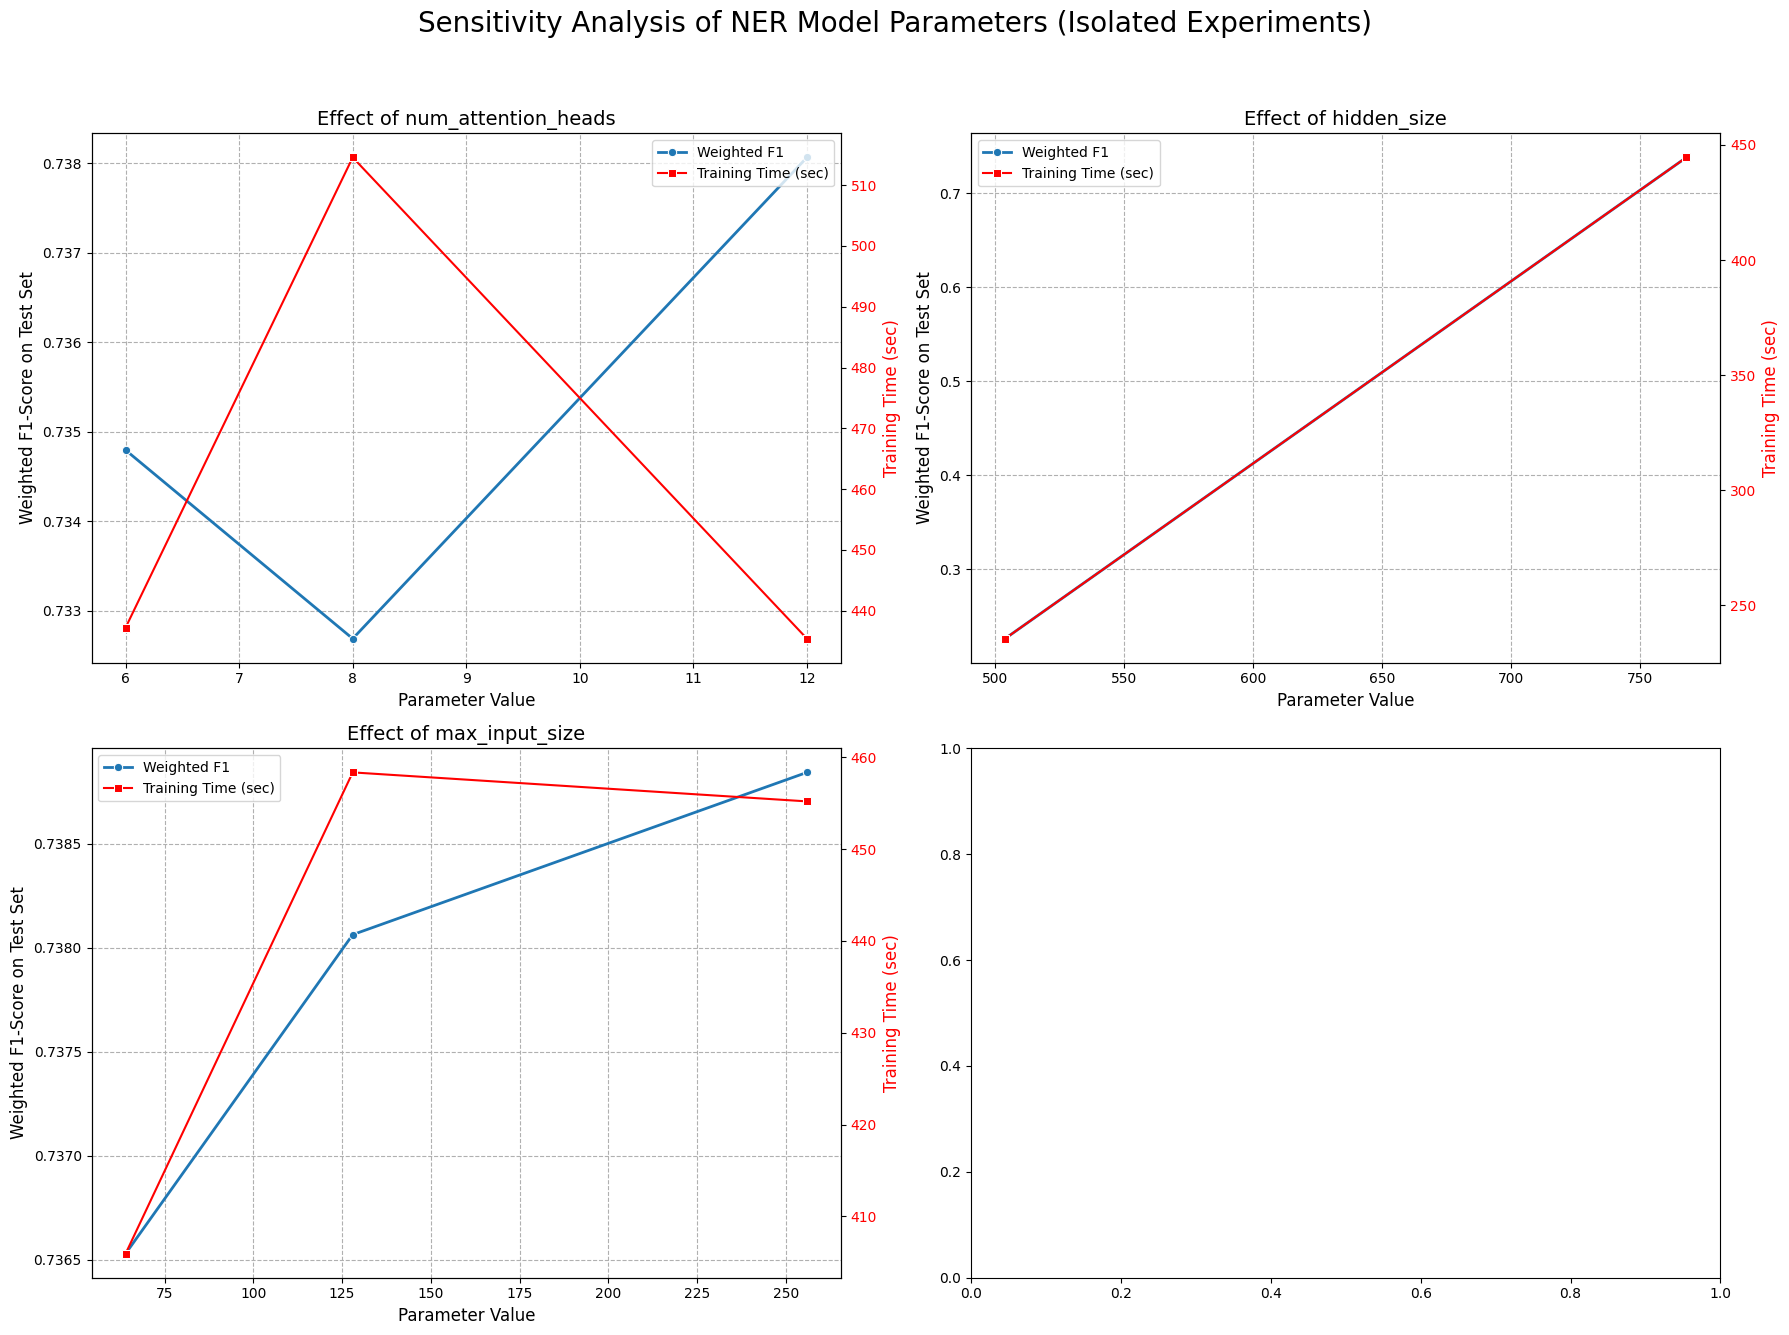

In [ ]:
param_name = "hidden_size"
for value in [504, 768]:
    print(f"\n===== Running Experiment: {param_name} = {value} =====")
    config = AutoConfig.from_pretrained(base_model, num_labels=len(label_names), id2label=id2label, label2id=label2id)
    config.hidden_size = value
    config.intermediate_size = value * 4
    model = AutoModelForTokenClassification.from_pretrained(base_model, config=config, ignore_mismatched_sizes=True)
    training_args = get_base_training_args(f"./results/{param_name}_{value}")
    eval_results, train_time = run_training(model, training_args, tokenized_datasets_base, tokenizer)
    all_results.append({"parameter": param_name, "value": value, "weighted_f1": eval_results.get("eval_weighted_f1", 0.0), "training_time_sec": train_time})

param_name = "max_input_size"
config_base = AutoConfig.from_pretrained(base_model, num_labels=len(label_names), id2label=id2label, label2id=label2id)
for value in [64, 128, 256]:
    print(f"\n===== Running Experiment: {param_name} = {value} =====")
    tokenized_datasets_varied_len = raw_datasets.map(
        tokenize_and_align_labels, batched=True,
        fn_kwargs={"tokenizer": tokenizer, "max_length": value},
        remove_columns=raw_datasets["train"].column_names
    )
    model = AutoModelForTokenClassification.from_pretrained(base_model, config=config_base)
    training_args = get_base_training_args(f"./results/{param_name}_{value}")
    eval_results, train_time = run_training(model, training_args, tokenized_datasets_varied_len, tokenizer)
    all_results.append({"parameter": param_name, "value": value, "weighted_f1": eval_results.get("eval_weighted_f1", 0.0), "training_time_sec": train_time})

results_df = pd.DataFrame(all_results)
print("\n\n--- FINAL RESULTS TABLE ---")
print(results_df.round(4))

print("\n\n--- PLOTTING RESULTS ---")
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Sensitivity Analysis of NER Model Parameters (Isolated Experiments)', fontsize=20)
axes = axes.flatten()

unique_params = results_df['parameter'].unique()
for i, param in enumerate(unique_params):
    subset_df = results_df[results_df['parameter'] == param]
    sns.lineplot(ax=axes[i], x='value', y='weighted_f1', data=subset_df, marker='o', lw=2, label='Weighted F1')
    ax2 = axes[i].twinx()
    sns.lineplot(ax=ax2, x='value', y='training_time_sec', data=subset_df, marker='s', color='red', label='Training Time (sec)')
    ax2.set_ylabel('Training Time (sec)', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')
    axes[i].set_title(f'Effect of {param}', fontsize=14)
    axes[i].set_xlabel('Parameter Value', fontsize=12)
    axes[i].set_ylabel('Weighted F1-Score on Test Set', fontsize=12)
    axes[i].grid(True, which='both', linestyle='--')
    lines, labels = axes[i].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    if axes[i].get_legend() is not None:
        axes[i].get_legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("sensitivity_analysis_isolated_corrected.png")
plt.show()


3

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
import time
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def normalize_labels(labels):
    return [[l.replace('_', '-') for l in s] for s in labels]

def load_data(tokens_path, labels_path):
    with open(tokens_path, 'r', encoding='utf-8') as f:
        tokens_lines = [line.strip().split() for line in f]
    with open(labels_path, 'r', encoding='utf-8') as f:
        labels_lines = [line.strip().split() for line in f]
    labels_lines = normalize_labels(labels_lines)
    data = {'tokens': [], 'ner_tags': []}
    for tokens, labels in zip(tokens_lines, labels_lines):
        if len(tokens) == len(labels):
            data['tokens'].append(tokens)
            data['ner_tags'].append(labels)
    return pd.DataFrame(data)

DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"
arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

arman_df = load_data(arman_tokens_path, arman_labels_path)

subset_df = arman_df.head(5000)
train_df, val_df = train_test_split(subset_df, test_size=0.15, random_state=42)
test_df = load_data(peyma_tokens_path, peyma_labels_path).head(1000)

class Vocabulary:
    def __init__(self, special_tokens=None):
        self.word2idx = {}
        self.idx2word = []
        if special_tokens:
            for token in special_tokens:
                self.add_word(token)
    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]
    def __len__(self):
        return len(self.idx2word)

special_tokens = ['<PAD>', '<UNK>']
word_vocab = Vocabulary(special_tokens)
label_vocab = Vocabulary()
for sentence in train_df['tokens']:
    for word in sentence:
        word_vocab.add_word(word)
for tags in train_df['ner_tags']:
    for tag in tags:
        label_vocab.add_word(tag)

class NERDataset(Dataset):
    def __init__(self, df, word_vocab, label_vocab, max_len=128):
        self.df = df
        self.word_vocab = word_vocab
        self.label_vocab = label_vocab
        self.max_len = max_len
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tokens = row['tokens']
        tags = row['ner_tags']
        token_ids = [self.word_vocab.word2idx.get(w, self.word_vocab.word2idx['<UNK>']) for w in tokens]
        tag_ids = [self.label_vocab.word2idx.get(t, 0) for t in tags]
        token_ids = token_ids[:self.max_len] + [self.word_vocab.word2idx['<PAD>']] * (self.max_len - len(token_ids))
        tag_ids = tag_ids[:self.max_len] + [-100] * (self.max_len - len(tag_ids))
        return torch.tensor(token_ids), torch.tensor(tag_ids)

train_dataset = NERDataset(train_df, word_vocab, label_vocab)
val_dataset = NERDataset(val_df, word_vocab, label_vocab)
test_dataset = NERDataset(test_df, word_vocab, label_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1)
        return self.dropout(x)

class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, num_classes, d_model=256, nhead=4, num_encoder_layers=2, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, src, src_padding_mask):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_padding_mask)
        output = self.classifier(output)
        return output

model = TransformerEncoderModel(
    vocab_size=len(word_vocab),
    num_classes=len(label_vocab),
    num_encoder_layers=2
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 500

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for tokens, tags in train_loader:
        tokens, tags = tokens.to(device), tags.to(device)
        padding_mask = (tokens == word_vocab.word2idx['<PAD>']).to(device)
        optimizer.zero_grad()
        output = model(tokens, padding_mask)
        loss = criterion(output.view(-1, len(label_vocab)), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

model.eval()
all_true_labels, all_pred_labels = [], []
with torch.no_grad():
    for tokens, tags in test_loader:
        tokens, tags = tokens.to(device), tags.to(device)
        padding_mask = (tokens == word_vocab.word2idx['<PAD>']).to(device)
        output = model(tokens, padding_mask)
        predictions = torch.argmax(output, dim=2)
        for i in range(tags.size(0)):
            true_seq, pred_seq = [], []
            for j in range(tags.size(1)):
                if tags[i, j].item() != -100:
                    true_seq.append(label_vocab.idx2word[tags[i, j].item()])
                    pred_seq.append(label_vocab.idx2word[predictions[i, j].item()])
            all_true_labels.append(true_seq)
            all_pred_labels.append(pred_seq)

report = classification_report(all_true_labels, all_pred_labels, scheme=IOB2, output_dict=True, zero_division=0)
f1_scratch_model = report["weighted avg"]["f1-score"]

f1_parsbert = 0.8875
comparison_df = pd.DataFrame({
    "Model": ["Transformer (From Scratch)"],
    "Weighted F1-Score": [f1_scratch_model]
})
print("\n--- result ---")
print(comparison_df)


Using device: cuda
Epoch 1/500, Loss: 0.6613
Epoch 2/500, Loss: 0.4894
Epoch 3/500, Loss: 0.4438
Epoch 4/500, Loss: 0.4088
Epoch 5/500, Loss: 0.3824
Epoch 6/500, Loss: 0.3573
Epoch 7/500, Loss: 0.3354
Epoch 8/500, Loss: 0.3138
Epoch 9/500, Loss: 0.3008
Epoch 10/500, Loss: 0.2852
Epoch 11/500, Loss: 0.2738
Epoch 12/500, Loss: 0.2619
Epoch 13/500, Loss: 0.2524
Epoch 14/500, Loss: 0.2419
Epoch 15/500, Loss: 0.2335
Epoch 16/500, Loss: 0.2259
Epoch 17/500, Loss: 0.2171
Epoch 18/500, Loss: 0.2121
Epoch 19/500, Loss: 0.2026
Epoch 20/500, Loss: 0.1960
Epoch 21/500, Loss: 0.1900
Epoch 22/500, Loss: 0.1824
Epoch 23/500, Loss: 0.1771
Epoch 24/500, Loss: 0.1719
Epoch 25/500, Loss: 0.1673
Epoch 26/500, Loss: 0.1625
Epoch 27/500, Loss: 0.1582
Epoch 28/500, Loss: 0.1509
Epoch 29/500, Loss: 0.1483
Epoch 30/500, Loss: 0.1434
Epoch 31/500, Loss: 0.1404
Epoch 32/500, Loss: 0.1348
Epoch 33/500, Loss: 0.1321
Epoch 34/500, Loss: 0.1274
Epoch 35/500, Loss: 0.1246
Epoch 36/500, Loss: 0.1221
Epoch 37/500, Loss

4

In [ ]:
!pip install -U transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [ ]:
!pip install -U timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.15
    Uninstalling timm-1.0.15:
      Successfully uninstalled timm-1.0.15


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from seqeval.metrics import f1_score, accuracy_score, classification_report
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"
arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

with open(arman_tokens_path, 'r', encoding='utf-8') as f:
    arman_sentences = [line.strip().split() for line in f.readlines()]
with open(arman_labels_path, 'r', encoding='utf-8') as f:
    arman_labels = [line.strip().split() for line in f.readlines()]
with open(peyma_tokens_path, 'r', encoding='utf-8') as f:
    peyma_sentences = [line.strip().split() for line in f.readlines()]
with open(peyma_labels_path, 'r', encoding='utf-8') as f:
    peyma_labels = [line.strip().split() for line in f.readlines()]

def unify_labels(labels_list):
    def get_entity_type(raw_label):
        if raw_label.strip().upper() == 'O':
            return 'O'
        m = re.match(r'^[BI][-_](.+)$', raw_label, flags=re.IGNORECASE)
        et = m.group(1) if m else raw_label
        et_clean = re.sub(r'[_-]', '', et).upper()
        mapping = {
            'PER': 'PER', 'PERS': 'PER', 'PERSON': 'PER',
            'LOC': 'LOC', 'LOCATION': 'LOC', 'FAC': 'LOC',
            'ORG': 'ORG', 'ORGANIZATION': 'ORG',
            'DAT': 'DAT', 'DATE': 'DAT',
            'TIM': 'TIM', 'TIME': 'TIM',
            'MON': 'MON', 'MONEY': 'MON',
            'PCT': 'PCT', 'PERCENT': 'PCT'
        }
        return mapping.get(et_clean, 'O')

    unified = []
    for sent in labels_list:
        temp = []
        prev_type = 'O'
        for raw in sent:
            etype = get_entity_type(raw)
            if etype == 'O':
                temp.append('O')
                prev_type = 'O'
            else:
                prefix = 'I-' if etype == prev_type else 'B-'
                temp.append(f"{prefix}{etype}")
                prev_type = etype
        unified.append(temp)
    return unified

arman_labels_unified = unify_labels(arman_labels)
peyma_labels_unified = unify_labels(peyma_labels)

arman_df = pd.DataFrame({'tokens': arman_sentences, 'ner_tags': arman_labels_unified})
train_df, val_df = train_test_split(arman_df, test_size=0.1, random_state=42)
test_df = pd.DataFrame({'tokens': peyma_sentences, 'ner_tags': peyma_labels_unified})

MODEL_NAME = 'HooshvareLab/bert-fa-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels = [label for df in [train_df, val_df, test_df] for sent in df['ner_tags'] for label in sent]
unique_labels = sorted(set(all_labels))
label_map = {lbl: idx for idx, lbl in enumerate(unique_labels)}
id_to_label = {idx: lbl for lbl, idx in label_map.items()}
NUM_LABELS = len(unique_labels)

flat = [label_map[l] for sent in train_df['ner_tags'] for l in sent]
present = np.unique(flat)
cw = compute_class_weight('balanced', classes=present, y=flat)
class_weights = np.zeros(NUM_LABELS, dtype=float)
for cls, w in zip(present, cw): class_weights[cls] = w
weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class NERDataset(Dataset):
    def __init__(self, df, tokenizer, label_map, max_len):
        self.df = df; self.tokenizer = tokenizer
        self.label_map = label_map; self.max_len = max_len
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        tokens = self.df.iloc[idx]['tokens']
        labels = self.df.iloc[idx]['ner_tags']
        enc = self.tokenizer(tokens, is_split_into_words=True, return_offsets_mapping=True,
                              padding='max_length', truncation=True, max_length=self.max_len,
                              return_tensors='pt')
        label_ids = np.ones(len(enc['offset_mapping'][0]), dtype=int) * -100
        i = 0
        for j, off in enumerate(enc['offset_mapping'][0]):
            if off[0]==0 and off[1]!=0 and i<len(labels):
                label_ids[j] = self.label_map[labels[i]]; i+=1
        item = {k:v.squeeze() for k,v in enc.items() if k!='offset_mapping'}
        item['labels'] = torch.tensor(label_ids)
        return item

train_loader = DataLoader(NERDataset(train_df, tokenizer, label_map, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(NERDataset(val_df, tokenizer, label_map, MAX_LEN), batch_size=BATCH_SIZE)
test_loader = DataLoader(NERDataset(test_df, tokenizer, label_map, MAX_LEN), batch_size=BATCH_SIZE)

class TransformerForNER(torch.nn.Module):
    def __init__(self, model_name, num_labels, strategy='last_layer', num_avg=4):
        super().__init__()
        self.strategy = strategy; self.num_avg = num_avg
        self.bert = AutoModel.from_pretrained(model_name, output_hidden_states=(strategy=='average_layers'))
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask, labels=None):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq = out.last_hidden_state if self.strategy=='last_layer' else torch.stack(out.hidden_states[-self.num_avg:]).mean(0)
        seq = self.dropout(seq)
        logits = self.classifier(seq)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-100)
            loss = loss_fct(logits.view(-1, NUM_LABELS), labels.view(-1))
        return (loss, logits) if labels is not None else logits

def train_epoch(model, loader, optimizer, scheduler):
    model.train(); total=0
    for batch in tqdm(loader, desc='Training'):
        optimizer.zero_grad()
        loss, _ = model(batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE), batch['labels'].to(DEVICE))
        loss.backward(); optimizer.step(); scheduler.step()
        total += loss.item()
    return total/len(loader)

def evaluate(model, loader):
    model.eval(); preds,labs=[],[]
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            logits = model(batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE))
            pred = torch.argmax(logits,2).cpu().numpy(); lab=batch['labels'].cpu().numpy()
            for p,l in zip(pred,lab):
                seq_p,seq_l=[],[]
                for pj,lj in zip(p,l):
                    if lj!=-100: seq_p.append(id_to_label[pj]); seq_l.append(id_to_label[lj])
                preds.append(seq_p); labs.append(seq_l)
    return accuracy_score(labs,preds), f1_score(labs,preds)

def run_experiment(strategy,num_avg=4):
    print(f"\nRunning: {strategy}")
    model = TransformerForNER(MODEL_NAME,NUM_LABELS,strategy,num_avg).to(DEVICE)
    optimizer=AdamW(model.parameters(),lr=3e-5)
    steps=len(train_loader)*1
    sched=get_linear_schedule_with_warmup(optimizer,0,steps)
    best_f1=0; best=None
    for epoch in range(1):
        print(f"Epoch {epoch+1}/1")
        loss=train_epoch(model,train_loader,optimizer,sched)
        print(f"Train Loss: {loss:.4f}")
        va,vf=_=evaluate(model,val_loader)
        print(f"Val Acc: {va:.4f}, F1: {vf:.4f}")
        if vf>best_f1: best_f1=vf; best=model.state_dict()
    print("\nTest Eval")
    model.load_state_dict(best)
    ta,tf=evaluate(model,test_loader)
    print(f"Test Acc: {ta:.4f}, F1: {tf:.4f}\n")
    return ta,tf

results={}
res1=run_experiment('last_layer'); results['Last Layer']={'Acc':res1[0],'F1':res1[1]}
res2=run_experiment('average_layers',4); results['Avg Last 4']={'Acc':res2[0],'F1':res2[1]}


Data files loaded successfully.
Labels unified successfully.

Running: last_layer
Epoch 1/1
Training: 100%|████████████████████████████████████████| 1297/1297 [09:13<00:00, 3.06it/s]
Train Loss: 0.1996
Evaluating: 100%|████████████████████████████████████████| 145/145 [00:23<00:00, 6.39it/s]
Val Acc: 0.9747, F1: 0.8003

Test Eval
Evaluating: 100%|████████████████████████████████████████| 624/624 [01:42<00:00, 6.00it/s]
Test Acc: 0.9295, F1: 0.6202


Running: average_layers
Epoch 1/1
Training: 100%|████████████████████████████████████████| 1297/1297 [09:14<00:00, 3.07it/s]
Train Loss: 0.2061
Evaluating: 100%|████████████████████████████████████████| 145/145 [00:23<00:00, 6.41it/s]
Val Acc: 0.9746, F1: 0.8055

Test Eval
Evaluating: 100%|████████████████████████████████████████| 624/624 [01:43<00:00, 7.23it/s]
Test Acc: 0.9309, F1: 0.6308


5

In [ ]:
!pip install --upgrade transformers

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import re
import warnings
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from seqeval.metrics import classification_report, f1_score
from seqeval.scheme import IOB2

warnings.filterwarnings("ignore")

print("--- Step 1: Loading and Preparing Data ---")

DRIVE_FOLDER_PATH = "/content/drive/MyDrive/nn/p7/"
arman_tokens_path = f"{DRIVE_FOLDER_PATH}arman-tokens.txt"
arman_labels_path = f"{DRIVE_FOLDER_PATH}arman-labels.txt"
peyma_tokens_path = f"{DRIVE_FOLDER_PATH}peyma-tokens.txt"
peyma_labels_path = f"{DRIVE_FOLDER_PATH}peyma-labels.txt"

try:
    with open(arman_tokens_path, 'r', encoding='utf-8') as f:
        arman_sentences = [line.strip().split() for line in f.readlines()]
    with open(arman_labels_path, 'r', encoding='utf-8') as f:
        arman_labels = [line.strip().split() for line in f.readlines()]
    with open(peyma_tokens_path, 'r', encoding='utf-8') as f:
        peyma_sentences = [line.strip().split() for line in f.readlines()]
    with open(peyma_labels_path, 'r', encoding='utf-8') as f:
        peyma_labels = [line.strip().split() for line in f.readlines()]
    print("Data files loaded successfully.")

    def unify_labels(labels_list):
        def get_entity_type(raw_label):
            if raw_label.strip().upper() == 'O':
                return 'O'
            m = re.match(r'^[BI][-_](.+)$', raw_label, flags=re.IGNORECASE)
            et = m.group(1) if m else raw_label
            et_clean = re.sub(r'[_-]', '', et).upper()
            mapping = {
                'PER': 'PER', 'PERS': 'PER', 'PERSON': 'PER',
                'LOC': 'LOC', 'LOCATION': 'LOC', 'FAC': 'LOC',
                'ORG': 'ORG', 'ORGANIZATION': 'ORG',
                'DAT': 'DAT', 'DATE': 'DAT',
                'TIM': 'TIM', 'TIME': 'TIM',
                'MON': 'MON', 'MONEY': 'MON',
                'PCT': 'PCT', 'PERCENT': 'PCT'
            }
            return mapping.get(et_clean, 'O')

        unified = []
        for sent in labels_list:
            temp = []
            prev_type = 'O'
            for raw in sent:
                etype = get_entity_type(raw)
                if etype == 'O':
                    temp.append('O')
                    prev_type = 'O'
                else:
                    prefix = 'I-' if etype == prev_type else 'B-'
                    temp.append(f"{prefix}{etype}")
                    prev_type = etype
            unified.append(temp)
        return unified

    arman_labels_unified = unify_labels(arman_labels)
    peyma_labels_unified = unify_labels(peyma_labels)
    print("Labels unified successfully.")

    arman_df = pd.DataFrame({'tokens': arman_sentences, 'ner_tags': arman_labels_unified})
    train_df, val_df = train_test_split(arman_df, test_size=0.1, random_state=42)
    test_df_original = pd.DataFrame({'tokens': peyma_sentences, 'ner_tags': peyma_labels_unified})

except FileNotFoundError:
    print(f"FATAL ERROR: Data files not found.")
    print("Script cannot continue. Please check your Google Drive path and file names.")
    test_df_original = pd.DataFrame()

if not test_df_original.empty:
    print("\n--- Step 2: Creating the Shuffled Dataset ---")

    def create_shuffled_dataset(df: pd.DataFrame) -> pd.DataFrame:
        shuffled_data = {'tokens': [], 'ner_tags': []}
        for _, row in df.iterrows():
            tokens = row['tokens']
            tags = row['ner_tags']
            indices = list(range(len(tokens)))
            random.shuffle(indices)
            shuffled_tokens = [tokens[i] for i in indices]
            shuffled_tags = [tags[i] for i in indices]
            shuffled_data['tokens'].append(shuffled_tokens)
            shuffled_data['ner_tags'].append(shuffled_tags)
        return pd.DataFrame(shuffled_data)

    test_df_shuffled = create_shuffled_dataset(test_df_original)

    print("Example of an original sentence with unified labels:")
    print("Tokens:", test_df_original.iloc[0]['tokens'])
    print("Tags:  ", test_df_original.iloc[0]['ner_tags'])
    print("\nExample of the same sentence (shuffled):")
    print("Tokens:", test_df_shuffled.iloc[0]['tokens'])
    print("Tags:  ", test_df_shuffled.iloc[0]['ner_tags'])

    print("\n--- Step 3: Converting DataFrames to Hugging Face Dataset Objects ---")
    raw_datasets = DatasetDict({
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test_original": Dataset.from_pandas(test_df_original.reset_index(drop=True)),
        "test_shuffled": Dataset.from_pandas(test_df_shuffled.reset_index(drop=True))
    })

    print("\n--- Step 4: Tokenization and Label Alignment ---")
    MODEL_CHECKPOINT = "HooshvareLab/bert-base-parsbert-uncased"
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
    all_labels = [lab for seq in train_df['ner_tags'] for lab in seq]
    label_names = sorted(list(set(all_labels)))
    label2id = {label: i for i, label in enumerate(label_names)}
    id2label = {i: label for i, label in label2id.items()}

    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(
            examples["tokens"], truncation=True, is_split_into_words=True, max_length=128
        )
        labels = []
        for i, label_sequence in enumerate(examples["ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None or word_idx == previous_word_idx:
                    label_ids.append(-100)
                else:
                    label_ids.append(label2id.get(label_sequence[word_idx], -100))
                previous_word_idx = word_idx
            labels.append(label_ids)
        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    tokenized_datasets = raw_datasets.map(
        tokenize_and_align_labels, batched=True, remove_columns=raw_datasets["train"].column_names
    )

    print("\n--- Step 5: Training the NER Model ---")
    config = AutoConfig.from_pretrained(
        MODEL_CHECKPOINT, num_labels=len(label_names), id2label=id2label, label2id=label2id
    )
    model = AutoModelForTokenClassification.from_pretrained(MODEL_CHECKPOINT, config=config)

    def compute_metrics(p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)
        true_predictions = [
            [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        f1 = f1_score(true_labels, true_predictions, average="macro")
        return {"macro_f1": f1}

    args = TrainingArguments(
        output_dir="ner-shuffle-test",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
    )
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )
    trainer.train()

    print("\n\n" + "="*50)
    print("--- Step 6: Evaluation on Original and Shuffled Data ---")
    print("="*50 + "\n")
    print("Evaluating on the original test set...")
    results_original = trainer.predict(tokenized_datasets["test_original"])
    f1_original = results_original.metrics.get('test_macro_f1', 0.0)
    print(f"Results on Original Data:\n{results_original.metrics}")
    print("\nEvaluating on the shuffled test set...")
    results_shuffled = trainer.predict(tokenized_datasets["test_shuffled"])
    f1_shuffled = results_shuffled.metrics.get('test_macro_f1', 0.0)
    print(f"Results on Shuffled Data:\n{results_shuffled.metrics}")

    print("\n\n" + "="*50)
    print("--- Step 7: Final Analysis and Conclusion ---")
    print("="*50 + "\n")
    comparison_data = {
        "Data Condition": ["Original Order", "Shuffled Order"],
        "Macro F1-Score": [f1_original, f1_shuffled]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print("Performance Comparison Table:")
    print(comparison_df.to_string(index=False))
    f1_drop_percentage = (1 - (f1_shuffled / f1_original)) * 100 if f1_original > 0 else 0
    print(f"\nPerformance Drop (Macro F1-Score): {f1_drop_percentage:.2f}%")


--- Step 1: Loading and Preparing Data ---
Data files loaded successfully.
Labels unified successfully.

--- Step 2: Creating the Shuffled Dataset ---
Example of an original sentence with unified labels:
Tokens: ['کرج', 'دومین', 'شهر', 'آلوده', 'کشور']
Tags:   ['B-LOC', 'O', 'O', 'O', 'O']

Example of the same sentence (shuffled):
Tokens: ['آلوده', 'شهر', 'کشور', 'کرج', 'دومین']
Tags:   ['O', 'O', 'O', 'B-LOC', 'O']

--- Step 3: Converting DataFrames to Hugging Face Dataset Objects ---

--- Step 4: Tokenization and Label Alignment ---


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/20738 [00:00<?, ? examples/s]

Map:   0%|          | 0/2305 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]

Map:   0%|          | 0/9979 [00:00<?, ? examples/s]


--- Step 5: Training the NER Model ---


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 7east1v (7east1v-amirkabir-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin




--- Step 6: Evaluation on Original and Shuffled Data ---

Evaluating on the original test set...


Results on Original Data:
{'test_loss': 0.1264350414276123, 'test_macro_f1': 0.7566897827587725, 'test_runtime': 42.3178, 'test_samples_per_second': 235.811, 'test_steps_per_second': 14.746}

Evaluating on the shuffled test set...


Results on Shuffled Data:
{'test_loss': 0.5700052976608276, 'test_macro_f1': 0.4329658666428142, 'test_runtime': 40.9533, 'test_samples_per_second': 243.668, 'test_steps_per_second': 15.237}


--- Step 7: Final Analysis and Conclusion ---

Performance Comparison Table:
Data Condition  Macro F1-Score
Original Order        0.756690
Shuffled Order        0.432966

Performance Drop (Macro F1-Score): 42.78%
